# NESTML active dendrite tutorial

In this tutorial, we create a neuron model with a "nonlinear" or "active" dendritic compartment, that can, independently from the soma, generate a (dendritic) action potential. The dendritic action potential is modeled here as the (somatic) membrane potential response to a rectangular (pulse shaped) dendritic current, parameterized by an amplitude and a duration. The rectangular shape can be interpreted as the approximation of an NMDA spike (Antic et al. 2010). A dendritic action potential is triggered when the total synaptic current exceeds a threshold.

The model we are building is an adapted version of the neuron model introduced by Memmesheimer et al. (2012) and Jahnke et al. (2012).

**Table of contents**
- [Pulse-shaped dendritic action potential](#section_pulse)
- [Dynamically controlling synaptic integration](#section_integration)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import os
import uuid
from pynestml.frontend.pynestml_frontend import to_nest, install_nest

NEST_SIMULATOR_INSTALL_LOCATION = "/home/beeblebrox/nest-simulator-build"   # XXX: CHANGE ME!


<a id='section_pulse'></a>
## Pulse-shaped dendritic action potential

We will use a standard, linear integrate-and-fire neuron with the governing equation:
    
\begin{align}
\frac{dV_m}{dt} &= -\frac{1}{\tau_m} (V_m - E_L) + \frac{1}{C_m} (I_{syn} + I_{dend\_ap})
\end{align}

Here, the term $I_{syn}$ contains all the currents flowing into the soma due to synaptic input, and $I_{dend\_ap}$ contains the contribution of an dendritic action potential.

### Implementing the pulse shape

The dendritic action potential is modeled here as a rectangular (pulse) function, parameterized by a height (current strength) and width (duration). 

```
parameters:
  I_dend_ap_peak pA = 150 pA   # current clamp value for I_dend during a dendritic action potential
  T_dend_ap ms = 10 ms         # time window over which the dendritic current clamp is active
  ...
```

We also define a synaptic current threshold that, when crossed, initiates the dendritic action potential:

```
parameters:
  I_th pA = 100 pA         # current-threshold for a dendritic action potential
  ...
```

The current is switched on and off as follows. When a dendritic action potential is triggered, the magnitude of the ``I_dend_ap`` current is set to ``I_dend_ap_ampl``, and a timer variable ``t_dend_ap`` is set to the duration of the current pulse, ``T_dend_ap``. At each future run of the NESTML ``update`` block, the timer is decremented until it reaches 0, at which point the dendritic action potential current ``I_dend_ap`` is set to zero, and the state of the synaptic integration is reset by setting ``I_dend`` and its derivative to zero.
```
update:
  if t_dend_ap > 0 ms:
    # during a dendritic action potential pulse
    t_dend_ap -= resolution()
    if t_dend_ap <= 0 ms:
      # end of dendritic action potential
      I_dend_ap = 0 pA
      t_dend_ap = 0 ms
    end
  end

  if I_dend > I_th:
    # current-threshold, emit a dendritic action potential
    t_dend_ap = T_dend_ap
    I_dend_ap = I_dend_ap_ampl
  end
```

The complete neuron is as follows. Two other somatic currents are also defined, and could correspond to, for example, AMPA and GABA currents on ports ``I_1`` and ``I_3``.

In [2]:
nestml_active_dend_model = '''
neuron iaf_psc_exp_nonlineardendrite:
  initial_values:
    V_m mV = 0 mV         # membrane potential
    t_dend_ap ms = 0 ms   # dendritic action potential timer
    I_dend_ap pA = 0 pA   # dendritic action potential current magnitude
  end

  equations:
    kernel I_kernel1 = exp(-t / tau_syn1)
    kernel I_kernel2 = (e / tau_syn2) * t * exp(-t / tau_syn2)
    kernel I_kernel3 = exp(-t / tau_syn3)

    recordable inline I_dend pA = convolve(I_kernel2, I_2)

    inline I_syn pA = convolve(I_kernel1, I_1) + I_dend + convolve(I_kernel3, I_3) + I_e

    V_m' = -(V_m - E_L) / tau_m + (I_syn + I_dend_ap) / C_m
  end

  parameters:
    C_m pF = 250 pF          # capacity of the membrane
    tau_m ms = 20 ms         # membrane time constant
    tau_syn1 ms = 10 ms      # time constant of synaptic current, port 1
    tau_syn2 ms = 10 ms      # time constant of synaptic current, port 2
    tau_syn3 ms = 10 ms      # time constant of synaptic current, port 3
    V_th mV = 25 mV          # action potential threshold
    V_reset mV = 0 mV        # reset voltage
    I_e    pA = 0 pA         # external current
    E_L    mV = 0 mV         # resting potential

    # dendritic action potential
    I_th pA = 100 pA            # current-threshold for a dendritic action potential
    I_dend_ap_peak pA = 150 pA  # current clamp value for I_dend during a dendritic action potential
    T_dend_ap ms = 10 ms        # time window over which the dendritic current clamp is active
  end

  input:
    I_1 pA <- spike
    I_2 pA <- spike
    I_3 pA <- spike
  end

  output: spike

  update:
    # solve ODEs
    integrate_odes()

    if t_dend_ap > 0 ms:
      t_dend_ap -= resolution()
      if t_dend_ap <= 0 ms:
        # end of dendritic action potential
        t_dend_ap = 0 ms
        I_dend_ap = 0 pA
      end
    end

    if I_dend > I_th:
      # current-threshold, emit a dendritic action potential
      t_dend_ap = T_dend_ap
      I_dend_ap = I_dend_ap_peak
    end

    # emit somatic action potential
    if V_m > V_th:
      emit_spike()
      V_m = V_reset
    end
  end
end
'''

Save to a temporary file and make the model available to instantiate in NEST (see [Running NESTML](https://nestml.readthedocs.io/en/latest/running.html)):

In [3]:
with open("iaf_psc_exp_nonlineardendrite.nestml", "w") as nestml_model_file:
    print(nestml_active_dend_model, file=nestml_model_file)

to_nest(input_path="iaf_psc_exp_nonlineardendrite.nestml",
        target_path="/tmp/nestml-active-dend-target",
        module_name="nestml_active_dend_module",
        suffix="_nestml",
        logging_level="ERROR") # try "INFO" for more debug information
install_nest("/tmp/nestml-active-dend-target", NEST_SIMULATOR_INSTALL_LOCATION)
nest.Install("nestml_active_dend_module")

### Running the simulation in NEST

Let's define a function that will instantiate the active dendrite model, run a simulation, and plot and return the results.

In [4]:
def evaluate_neuron(neuron_name, neuron_parms=None, t_sim=100., plot=True):
    """
    Run a simulation in NEST for the specified neuron. Inject a stepwise
    current and plot the membrane potential dynamics and action potentials generated.
    """
    dt = .1   # [ms]

    MAX_SSE = 1E-12

    I_dend_alias_name = 'I_dend'

    nest.ResetKernel()
    try:
        nest.Install("nestml_active_dend_module")
    except :
        pass
    neuron = nest.Create(neuron_name)
    if neuron_parms:
        for k, v in neuron_parms.items():
            nest.SetStatus(neuron, k, v)

    sg = nest.Create("spike_generator", params={"spike_times": [10., 20., 30., 40., 50.]})
    
    multimeter = nest.Create("multimeter")
    record_from_vars = ["V_m", I_dend_alias_name]
    if "dend_curr_enabled" in neuron.get().keys():
        record_from_vars += ["dend_curr_enabled"]
    multimeter.set({"record_from": record_from_vars,
                    "interval": dt})
    sr_pre = nest.Create("spike_recorder")
    sr = nest.Create("spike_recorder")

    nest.Connect(sg, neuron, syn_spec={"receptor_type": 2, "weight": 50., "delay": 1.})
    nest.Connect(multimeter, neuron)
    nest.Connect(sg, sr_pre)
    nest.Connect(neuron, sr)
    
    nest.Simulate(t_sim)

    mm = nest.GetStatus(multimeter)[0]
    Voltages = mm["events"]["V_m"]
    tv = mm["events"]["times"]
    dSD = nest.GetStatus(sr, keys='events')[0]
    spikes = dSD['senders']
    ts = dSD["times"]
    
    _idx = [np.argmin((tv - spike_time)**2) - 1 for spike_time in ts]
    V_m_at_spike_times = Voltages[_idx]
    timevec = mm.get("events")["times"]
    I_dend_alias_ts = mm.get("events")[I_dend_alias_name]
    if "dend_curr_enabled" in mm.get("events").keys():
        dend_curr_enabled = mm.get("events")["dend_curr_enabled"]

    ts_sp = nest.GetStatus(sr, keys='events')[0]['times']
    ts_pre_sp = nest.GetStatus(sr_pre, keys='events')[0]['times']
    
    if plot:
        n_subplots = 2
        if "dend_curr_enabled" in mm.get("events").keys():
            n_subplots += 1
        fig, ax = plt.subplots(n_subplots, 1, dpi=100)
        ax[0].scatter(ts_pre_sp, np.zeros_like(ts_pre_sp), marker="v", c="orange", alpha=.8, zorder=99)
        ax[0].plot(timevec, I_dend_alias_ts, label="I_dend")
        if "dend_curr_enabled" in mm.get("events").keys():
            ax[1].plot(timevec, dend_curr_enabled, label="dend_curr_enabled")
            ax[1].set_ylim([-.05, 1.05])
            ax[1].set_yticks([0, 1])
        ax[-1].plot(timevec, mm.get("events")["V_m"], label="V_m")
        ax[-1].scatter(ts_sp, np.zeros_like(ts_sp), marker="v", c="orange", alpha=.8, zorder=99)
        for _ax in ax:
            _ax.legend()
            _ax.grid()
        fig.show()


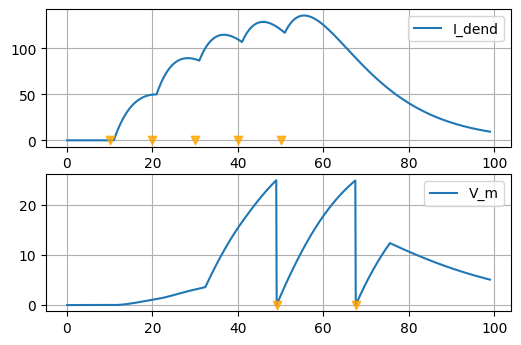

In [5]:
evaluate_neuron("iaf_psc_exp_nonlineardendrite_nestml", neuron_parms={"I_th": 100., "I_dend_ap_peak": 400.})

The presynaptic action potentials by themselves are not sufficient by themselves to trigger a postsynaptic action potential:

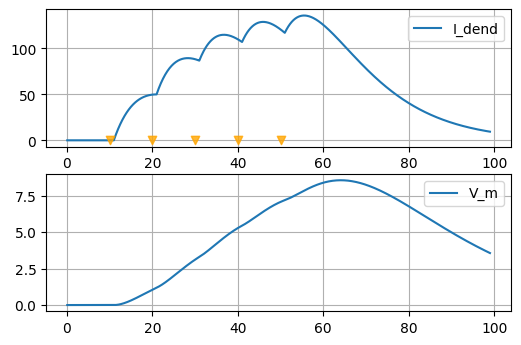

In [6]:
evaluate_neuron("iaf_psc_exp_nonlineardendrite_nestml", neuron_parms={"I_th": 9999.})

<a id='section_integration'></a>
## Dynamically controlling synaptic integration

We now add the additional requirement for the dendritic action potential to disable synaptic integration. When a dendritic action potential happens, we want to ignore synaptic currents for the duration of the action potential, and to reset the synaptic currents such that any presynaptic activity before the dendritic action potential is ignored.

To do this, we add a state variable ``dend_curr_enabled``, that will have the value 1 if synaptic current integration is enabled, and 0 in case it is disabled. This variables multiplies the ``I_syn`` term in the differential equation for $V_m$. The new governing equation is then:

\begin{align}
\frac{dV_m}{dt} &= -\frac{1}{\tau_m} (V_m - E_L) + \frac{1}{C_m} (\mathtt{dend\_curr\_enabled} \cdot I_{syn} + I_{dend\_ap})
\end{align}

We can then temporarily disable the synaptic current from contributing to the update of ``V_m`` by setting ``dend_curr_enabled`` to zero, for instance:

```
update:
  if I_dend > I_th:
    # current-threshold, emit a dendritic action potential
    ...
    # temporarily pause synaptic integration
    dend_curr_enabled = 0.
    ...
```

In order to ignore presynaptic input that arrives during and before a dendritic action potential, we use the inline aliasing feature of NESTML. Usually, synaptic integration is expressed as a convolution, for example:

```nestml
equations:
  kernel syn_kernel = exp(-t / tau_syn)

  V_m' = -(V_m - E_L) / tau_m + convolve(syn_kernel, in_spikes) / C_m
  ...
```

We will define an inline expression that aliases this convolution (see https://nestml.readthedocs.io/en/latest/nestml_language.html#%28Re%29setting-synaptic-integration-state for a more detailed explanation):

```
equations:
  inline I_syn pA = convolve(syn_kernel, in_spikes)
  ...
```

Now, we can not only use the variable ``I_syn`` in expressions, but we can also assign to it. To reset the state of synaptic integration (thereby "forgetting" any past action potential events):

```
update:
  ...
    if t_dend_ap <= 0 ms:
      # end of dendritic action potential
      ...
      # reset and re-enable synaptic integration
      I_dend = 0 pA
      I_dend' = 0 pA/ms
      dend_curr_enabled = 1.
    end
  end

```

Putting it all together in a new model, we have:

In [7]:
nestml_active_dend_reset_model = '''
neuron iaf_psc_exp_nonlineardendrite_resetting:
  initial_values:
    V_m mV = 0 mV         # membrane potential
    t_dend_ap ms = 0 ms   # dendritic action potential timer
    dend_curr_enabled real = 1.   # set to 1 to allow synaptic dendritic currents 
                                  # to contribute to V_m integration, 0 otherwise
    I_dend_ap pA = 0 pA
  end

  equations:
    kernel I_kernel1 = exp(-t / tau_syn1)
    kernel I_kernel2 = (e / tau_syn2) * t * exp(-t / tau_syn2)
    kernel I_kernel3 = exp(-t / tau_syn3)

    recordable inline I_dend pA = convolve(I_kernel2, I_2)

    inline I_syn pA = convolve(I_kernel1, I_1) + dend_curr_enabled * I_dend + convolve(I_kernel3, I_3) + I_e

    V_m' = -(V_m - E_L) / tau_m + (I_syn + I_dend_ap) / C_m
  end

  parameters:
    C_m pF = 250 pF          # capacity of the membrane
    tau_m ms = 20 ms         # membrane time constant
    tau_syn1 ms = 10 ms      # time constant of synaptic current, port 1
    tau_syn2 ms = 10 ms      # time constant of synaptic current, port 2
    tau_syn3 ms = 10 ms      # time constant of synaptic current, port 3
    V_th mV = 25 mV          # action potential threshold
    V_reset mV = 0 mV        # reset voltage
    I_e    pA = 0 pA         # external current
    E_L    mV = 0 mV         # resting potential

    # dendritic action potential
    I_th pA = 100 pA             # current-threshold for a dendritic action potential
    I_dend_ap_peak pA = 150 pA   # current clamp value for I_dend during a dendritic action potential
    T_dend_ap ms = 10 ms         # time window over which the dendritic current clamp is active
  end

  input:
    I_1 pA <- spike
    I_2 pA <- spike
    I_3 pA <- spike
  end

  output: spike

  update:
    # solve ODEs
    integrate_odes()

    if t_dend_ap > 0 ms:
      t_dend_ap -= resolution()
      if t_dend_ap <= 0 ms:
        I_dend_ap = 0 pA
        t_dend_ap = 0 ms
        # reset and re-enable synaptic integration
        I_dend = 0 pA
        I_dend' = 0 pA/ms
        dend_curr_enabled = 1.
      end
    end

    if I_dend > I_th:
      # current-threshold, emit a dendritic action potential
      t_dend_ap = T_dend_ap
      I_dend_ap = I_dend_ap_peak
      # temporarily pause synaptic integration
      dend_curr_enabled = 0.
    end

    # emit somatic action potential
    if V_m > V_th:
      emit_spike()
      V_m = V_reset
    end
  end
end
'''

Save to a temporary file and make the model available to instantiate in NEST (see [Running NESTML](https://nestml.readthedocs.io/en/latest/running.html)):

In [8]:
with open("iaf_psc_exp_nonlineardendrite.nestml", "w") as nestml_model_file:
    print(nestml_active_dend_reset_model, file=nestml_model_file)

to_nest(input_path="iaf_psc_exp_nonlineardendrite.nestml",
        target_path="/tmp/nestml-active-dend-target",
        module_name="nestml_active_dend_reset_module",
        suffix="_nestml",
        logging_level="ERROR") # try "INFO" for more debug information
install_nest("/tmp/nestml-active-dend-target", NEST_SIMULATOR_INSTALL_LOCATION)
nest.Install("nestml_active_dend_reset_module")



If we run the simulation with the same parameters as last time, we now observe only one instead of two action potentials, because the synaptic current (shown as ``I_dend`` in the top subplot below) does not contribute to ``V_m`` during the dendritic action potential interval.

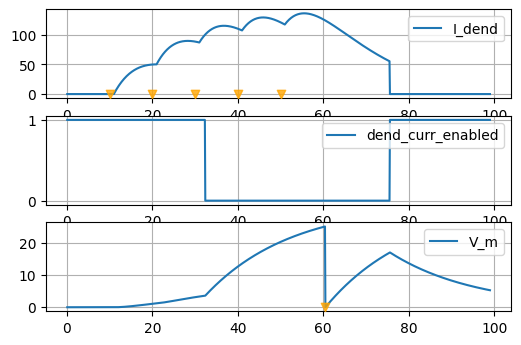

In [9]:
evaluate_neuron("iaf_psc_exp_nonlineardendrite_resetting_nestml",
                neuron_parms={"I_th": 100., "I_dend_ap_peak": 400.})

## Acknowledgements

We extend our gratitude to Younes Bouhadjar and Tom Tetzlaff for their contributions.

This software was developed in part or in whole in the Human Brain Project, funded from the European Union’s Horizon 2020 Framework Programme for Research and Innovation under Specific Grant Agreements No. 720270 and No. 785907 (Human Brain Project SGA1 and SGA2).


## References

Jahnke, S., Timme, M. & Memmesheimer, R. M. (2012). Guiding synchrony through random networks. Physical Review X, 2(4), 041016. https://doi.org/10.1103/PhysRevX.2.041016

Memmesheimer, R. M. & Timme, M. (2012). Non-additive coupling enables propagation of synchronous spiking activity in purely random networks. PLoS Comput Biol, 8(4), e1002384. https://doi.org/10.1371/journal.pcbi.1002384

Antic, S.D. Zhou, W.-L., Moore, A.R., Short, S.M., & Ikonomu, K.D. (2010). The Decade of the Dendritic NMDA Spike. J Neurosci Res. Nov 1, 88(14). https://doi.org/10.1002/jnr.22444


## Copyright

This file is part of NEST.

Copyright (C) 2004 The NEST Initiative

NEST is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 2 of the License, or (at your option) any later version.

NEST is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with NEST.  If not, see <http://www.gnu.org/licenses/>.
